# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.29 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
import numpy as np
import pandas as pd
import random
import copy
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from model import Actor, Critic
from agent import Agent
from multi_agents import Agents

In [3]:
from unityagents import UnityEnvironment

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Train the Agents with DDPG

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [13]:
def plot_scores(scores, rolling_window=10, save_fig=False):
    """Plot scores and optional rolling mean using specified window."""
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, label='scores')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title(f'scores')
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean, label='mean scores 10 epochs')
    plt.legend()

    if save_fig:
        plt.savefig(f'./images/figures_scores.png', bbox_inches='tight', pad_inches=0)

In [7]:
#Case 20 agents
agents = Agents(state_size=state_size, action_size=action_size,
              n_agents=num_agents, random_seed=10)

In [8]:
def ddpg_20agents(n_episodes=10000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations  
        agents.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            actions = agents.act(states)
            
            env_info = env.step(actions)[brain_name]   
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                                  # get reward (for each agent)
            dones = env_info.local_done                                 # see if episode finished

            agents.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if any(dones):
                break 
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agents.actor_local.state_dict(), './saved_models/checkpoint_actor_20agents.pth')
        torch.save(agents.critic_local.state_dict(), './saved_models/checkpoint_critic_20agents.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            plot_scores(scores)
        if np.mean(scores_deque) >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - print_every, np.mean(scores_deque)))
            torch.save(agents.actor_local.state_dict(), './saved_models/checkpoint_actor_20agents.pth')
            torch.save(agents.critic_local.state_dict(), './saved_models/checkpoint_critic_20agents.pth')
            break
            
    return scores

Episode 100	Average Score: 0.69
Episode 200	Average Score: 11.27
Episode 274	Average Score: 30.05
Environment solved in 174 episodes!	Average Score: 30.05


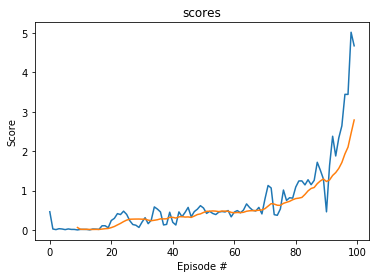

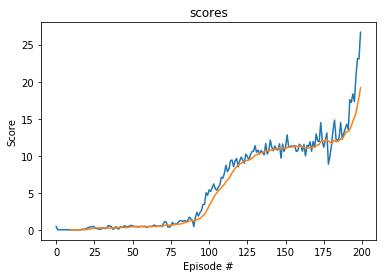

In [24]:
scores_20agents = ddpg_20agents(n_episodes = 1000)

Results visualization

### 4. Test the trained model

#### 20 agents

In [9]:
# Load the saved weights into Pytorch model
agents.actor_local.load_state_dict(torch.load('./saved_models/checkpoint_actor_20agents.pth', map_location='cpu'))
agents.critic_local.load_state_dict(torch.load('./saved_models/checkpoint_critic_20agents.pth', map_location='cpu'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

while True:
    actions = agents.act(states)                        # select actions from loaded model agent
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score: {}'.format(np.mean(scores)))

Total score: 37.78349915547297


In [ ]:
agents.actor_local.eval()

Actor(
  (fc1): Linear(in_features=33, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
agents.critic_local.eval()

Critic(
  (fcs1): Linear(in_features=33, out_features=256, bias=True)
  (fc2): Linear(in_features=260, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
)

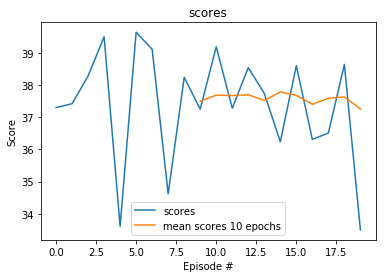

In [ ]:
plot_scores(scores)

Close the environment when finished.

In [ ]:
env.close()